In [1]:
from pathlib import Path
import pandas as pd

data_dir = Path.cwd() / "data"
jobs = ["IOPFPlanets20220823Massive"]

argfiles = [argfile for job in jobs for argfile in (data_dir / job).glob("*/args.json")]
sims_records = pd.DataFrame.from_records(pd.read_json(argfile, typ="series") for argfile in argfiles)
sims_paths = pd.DataFrame.from_records({"run": argfile.parent.name, "path": argfile.parent} for argfile in argfiles)
sims_df = pd.concat([sims_records, sims_paths], axis="columns")

In [2]:
import rebound

sim_cache = {}
for i, rebound_path in (sims_df["path"] / sims_df["rebound_archive"]).items():
    sa = rebound.SimulationArchive(str(rebound_path))
    final = sa[-1]
    sim_cache[sims_df.at[i, "run"]] = {
        "sa": sa,
        "final": final,
        "byindex": {

        },
        "h5path": next(sims_df.at[i, "path"].glob("*.h5"))
    }

def load_sim_from_cache(run, time):
    sa = sim_cache[run]["sa"]
    _i, _ = sa._getSnapshotIndex(time)
    if _i in sim_cache[run]["byindex"]:
        return sim_cache[run]["byindex"][_i]
    else:
        sim = sa[_i]
        sim_cache[run]["byindex"][_i] = sim
        return sim

/home/alchzh/cassum-2022-project-21/workspace/src/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [3]:
import numpy as np

NaN = float("NaN")

def FINAL_STATS(sim):
    final = sim_cache[sim["run"]]["final"]
    
    stats = np.array([(p.m, p.a, p.P) for p in final.particles[1:]]).T
    N = len(stats[0])
    M_TOT = stats[0].sum()

    top2 = stats[:, np.argsort(stats[0])[-1:-3:-1]]
    if N < 2:
        top2 = np.column_stack([top2, np.full_like(top2, NaN)])
    
    m, a, P = top2  

    return pd.Series({
        "FINAL_N": N,
        "FINAL_M_TOT": M_TOT,

        "FINAL_M_PRI": m[0],
        "FINAL_P_PRI": P[0],
        "FINAL_A_PRI": a[0],

        "FINAL_M_SEC": m[1],
        "FINAL_P_SEC": P[1],
        "FINAL_A_SEC": a[1],

        "FINAL_M_RAT_PRI_TOT": m[0] / M_TOT,
        "FINAL_M_RAT_SEC_TOT": m[1] / M_TOT,
        "FINAL_M_RAT_PRI_SEC": m[0] / m[1],
        "FINAL_P_RAT_PRI_SEC": P[0] / P[1],
    })

final_df = sims_df.apply(FINAL_STATS, axis=1)
final_df["FINAL_N"] = final_df["FINAL_N"].astype(np.int_)
sims_ext_df = sims_df.join(final_df)
sims_ext_df

,seed,t_end,N_end,N_enddelay,store_dt,n_p,code,a_in,a_out,alpha,...,FINAL_M_PRI,FINAL_P_PRI,FINAL_A_PRI,FINAL_M_SEC,FINAL_P_SEC,FINAL_A_SEC,FINAL_M_RAT_PRI_TOT,FINAL_M_RAT_SEC_TOT,FINAL_M_RAT_PRI_SEC,FINAL_P_RAT_PRI_SEC
0,50085,2000000.0,1,1.0,1000.0,100,rebound,0.222,0.232,-2,...,0.000002,0.108901,0.228046,1.105530e-06,0.090732,0.201918,0.599943,0.368174,1.629508,1.200251
1,77780,2000000.0,1,1.0,1000.0,100,rebound,0.222,0.232,-2,...,0.000003,0.103298,0.220154,3.196516e-07,0.152421,0.285341,0.889480,0.106453,8.355573,0.677711
2,24392,2000000.0,1,1.0,1000.0,100,rebound,0.222,0.232,-2,...,0.000001,0.109096,0.228318,9.829782e-07,0.090906,0.202175,0.359892,0.327361,1.099373,1.200102
3,70010,2000000.0,1,1.0,1000.0,100,rebound,0.222,0.232,-2,...,0.000002,0.091395,0.202900,1.003661e-06,0.127403,0.253194,0.546585,0.334249,1.635264,0.717371
4,24962,2000000.0,1,1.0,1000.0,100,rebound,0.222,0.232,-2,...,0.000002,0.112055,0.232427,9.933148e-07,0.087851,0.197620,0.627023,0.330803,1.895455,1.275515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,93677,2000000.0,1,1.0,1000.0,100,rebound,0.222,0.232,-2,...,0.000001,0.102037,0.218360,6.388078e-07,0.120085,0.243403,0.457330,0.212742,2.149695,0.849711
60,86879,2000000.0,1,1.0,1000.0,100,rebound,0.222,0.232,-2,...,0.000002,0.108743,0.227825,6.611989e-07,0.085839,0.194592,0.776474,0.220199,3.526241,1.266819
61,28077,2000000.0,1,1.0,1000.0,100,rebound,0.222,0.232,-2,...,0.000002,0.123046,0.247388,1.256814e-06,0.089971,0.200787,0.578392,0.418556,1.381873,1.367619
62,65472,2000000.0,1,1.0,1000.0,100,rebound,0.222,0.232,-2,...,0.000002,0.108796,0.227899,8.338115e-07,0.087045,0.196409,0.656293,0.277684,2.363452,1.249887


In [4]:
groups = sims_ext_df.groupby(["C_d", "migration_torque"])

mins = groups.min().add_suffix("_MIN")
maxes = groups.max().add_suffix("_MAX")
means = groups.mean().add_suffix("_MEAN")
medians = groups.median().add_suffix("_MEDIAN")

summary = pd.concat([mins, maxes, means, medians], axis=1).filter(like="FINAL")
summary

FINAL_N_MIN  FINAL_M_TOT_MIN  FINAL_M_PRI_MIN  \
C_d  migration_torque                                                  
0.00 False                       2         0.000003         0.000002   
     True                        1         0.000003         0.000002   
0.44 False                       3         0.000003         0.000001   
     True                        3         0.000003         0.000001   

                       FINAL_P_PRI_MIN  FINAL_A_PRI_MIN  FINAL_M_SEC_MIN  \
C_d  migration_torque                                                      
0.00 False                    0.091651         0.203278     3.196516e-07   
     True                     0.108675         0.227730     1.903142e-08   
0.44 False                    0.090422         0.201458     3.880898e-07   
     True                     0.108497         0.227481     2.684563e-07   

                       FINAL_P_SEC_MIN  FINAL_A_SEC_MIN  \
C_d  migration_torque                                     
0.00 False                    0.080346         0.186199   
     True                     0.084592         0.192702   
0.44 False                    0.086833         0.196090   
     True                     0.081540         0.188039   

                       FINAL_M_RAT_PRI_TOT_MIN  FINAL_M_RAT_SEC_TOT_MIN  ...  \
C_d  migration_torque                                                    ...   
0.00 False                            0.525897                 0.106453  ...   
     True                             0.599943                 0.006338  ...   
0.44 False                            0.423057                 0.129245  ...   
     True                             0.359892                 0.089404  ...   

                       FINAL_M_PRI_MEDIAN  FINAL_P_PRI_MEDIAN  \
C_d  migration_torque                                           
0.00 False                       0.000002            0.110258   
     True                        0.000002            0.108717   
0.44 False                       0.000002            0.111284   
     True                        0.000002            0.108806   

                       FINAL_A_PRI_MEDIAN  FINAL_M_SEC_MEDIAN  \
C_d  migration_torque                                           
0.00 False                       0.229936        9.160991e-07   
     True                        0.227789        7.137530e-07   
0.44 False                       0.231361        8.115207e-07   
     True                        0.227913        9.147845e-07   

                       FINAL_P_SEC_MEDIAN  FINAL_A_SEC_MEDIAN  \
C_d  migration_torque                                           
0.00 False                       0.090856            0.202099   
     True                        0.129758            0.256304   
0.44 False                       0.100350            0.215939   
     True                        0.092121            0.203969   

                       FINAL_M_RAT_PRI_TOT_MEDIAN  FINAL_M_RAT_SEC_TOT_MEDIAN  \
C_d  migration_torque                                                           
0.00 False                               0.620259                    0.305088   
     True                                0.760427                    0.237701   
0.44 False                               0.520269                    0.270261   
     True                                0.576295                    0.304650   

                       FINAL_M_RAT_PRI_SEC_MEDIAN  FINAL_P_RAT_PRI_SEC_MEDIAN  
C_d  migration_torque                                                          
0.00 False                               2.279244                    1.274718  
     True                                3.184160                    0.837698  
0.44 False                               1.786373                    1.254475  
     True                                2.060645                    1.200036  

[4 rows x 48 columns]

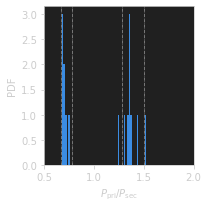

In [5]:
import matplotlib.pyplot as plt
from matplotlib.rcsetup import cycler

fg = "#ccc"

plt.rc("axes", prop_cycle=cycler(color=["3b8ce2"]), facecolor="202020", labelcolor=fg, edgecolor=fg)
plt.rc("figure", facecolor="none")
plt.rc("xtick", color=fg, labelcolor=fg)
plt.rc("ytick", color=fg, labelcolor=fg)
plt.rc("text", color=fg)

dgroups = dict(list(groups))
base = dgroups[(0.0, False)]

base["FINAL_P_RAT_PRI_SEC"].plot.hist(bins=np.arange(0.5, 2.0, 0.016), figsize=(3, 3))

ax = plt.gca()
ax.autoscale(False)
ax.vlines([2/3, 7/9, 9/7, 3/2], 0, 5.5, color=fg, linestyles="dashdot", lw=0.5)

ax.set_xlim(0.5, 2.0)
ax.set_xticks([0.5, 1.0, 1.5, 2.0])
ax.set_xlabel(r"$P_{\mathrm{pri}}/P_{\mathrm{sec}}$")

ax.set_ylabel("PDF")

plt.tight_layout()

# plt.savefig("images/ppripsec.png", dpi=200)

In [62]:
ORDER = [
    "FINAL_M_RAT_PRI_SEC",
    "FINAL_M_RAT_PRI_TOT"
]

SUFFIX = [
    "MIN",
    "MAX",
    "MEAN",
    "MEDIAN"
]

COLS = [f"{b}_{s}" for b in ORDER for s in SUFFIX]
summary[COLS].to_csv("new_summary.tsv", sep="&", float_format="%.2f")

/home/alchzh/cassum-2022-project-21/workspace/src/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


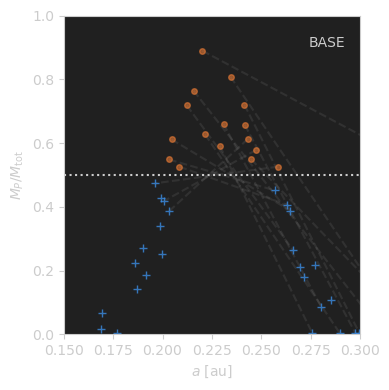

In [11]:
import matplotlib.pyplot as plt
from matplotlib.rcsetup import cycler
import matplotlib

matplotlib.colors.ColorConverter.colors['cassum:orange'] = "#e77a35"
matplotlib.colors.ColorConverter.colors['cassum:blue'] = "#3b8ce2"

matplotlib.colors.cnames['cassum:orange'] = "#e77a35"
matplotlib.colors.cnames['cassum:blue'] = "#3b8ce2"


fg = "#ccc"

plt.rc("axes", prop_cycle=cycler(color=["e77a35", "3b8ce2"]), facecolor="202020", labelcolor=fg, edgecolor=fg)
plt.rc("figure", facecolor="none")
plt.rc("xtick", color=fg, labelcolor=fg)
plt.rc("ytick", color=fg, labelcolor=fg)
plt.rc("text", color=fg)

def sim_group(row):
    g = 0
    if row["C_d"] == 0.44:
        g += 2
    if row["migration_torque"]:
        g += 1
    return g

def standard_label(axs, **kwargs):
    axs[0][0].annotate("BASE", **kwargs)
    # axs[0][1].annotate("TORQUE", **kwargs)
    # axs[1][0].annotate("DRAG", **kwargs)
    # axs[1][1].annotate("DRAG+TORQUE", **kwargs)

# fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
fig, axs = plt.subplots(1, 1, squeeze=False, figsize=(4, 4))
axs_r = np.ravel(axs)

for _i, row in sims_ext_df.iterrows():
    g = sim_group(row)
    if g != 0:
        continue
    ax = axs_r[g]

    final =  load_sim_from_cache(row["run"], 2000000)
    m = np.array([p.m for p in final.particles[1:]])
    M_TOT = np.sum(m)
    ipri = np.argmax(m)

    _p = None
    _s = None
    for i, p in enumerate(final.particles[1:]):
        if i == ipri:
            ax.plot(p.a, p.m / M_TOT, marker="o", c="cassum:orange", alpha=0.6, ms=4)
            _p = (p.a, p.m / M_TOT)
        else:
            ax.plot(p.a, p.m / M_TOT, marker="+", c="cassum:blue", alpha=0.8)
            _s = (p.a, p.m / M_TOT)

    ax.plot(*zip(_p, _s), "--", color=fg, zorder=-1, alpha=0.1)

for ax in axs_r:
    ax.set_xlim(0.15, 0.30)
    ax.set_ylim(0, 1.0)
    ax.hlines(0.5, *ax.get_xlim(), linestyles="dotted", color=fg)

for row in range(axs.shape[0]):
    axs[row, 0].set_ylabel(r"$M_P/M_{\mathrm{tot}}$")

for col in range(axs.shape[1]):
    axs[-1, col].set_xlabel(r"$a$ [au]")

standard_label(axs, xy=(0.95, 0.90), xycoords='axes fraction', horizontalalignment="right")

fig.tight_layout()
# plt.savefig("images/base.png", dpi=200)
plt.show()

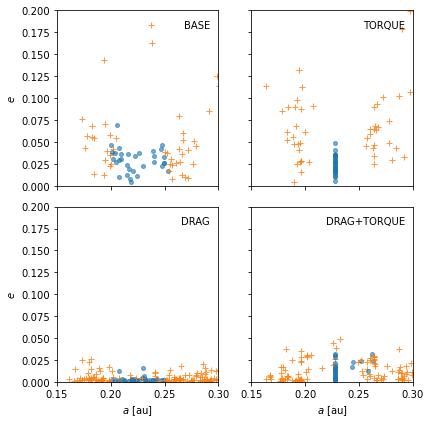

In [7]:
import matplotlib.pyplot as plt

def sim_group(row):
    g = 0
    if row["C_d"] == 0.44:
        g += 2
    if row["migration_torque"]:
        g += 1
    return g

def standard_label(axs, **kwargs):
    axs[0][0].annotate("BASE", **kwargs)
    axs[0][1].annotate("TORQUE", **kwargs)
    axs[1][0].annotate("DRAG", **kwargs)
    axs[1][1].annotate("DRAG+TORQUE", **kwargs)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
axs_r = np.ravel(axs)

for _i, row in sims_ext_df.iterrows():
    g = sim_group(row)
    ax = axs_r[g]

    final =  load_sim_from_cache(row["run"], 2000000)
    m = np.array([p.m for p in final.particles[1:]])
    M_TOT = np.sum(m)
    ipri = np.argmax(m)

    for i, p in enumerate(final.particles[1:]):
        if i == ipri:
            ax.plot(p.a, p.e, marker="o", c="tab:blue", alpha=0.6, ms=4)
        else:
            ax.plot(p.a, p.e, marker="+", c="tab:orange", alpha=0.8)

for ax in axs_r:
    ax.set_xlim(0.15, 0.30)
    ax.set_ylim(0, 0.2)

axs[0][0].set_ylabel(r"$e$")
axs[1][0].set_ylabel(r"$e$")

axs[1][0].set_xlabel(r"$a$ [au]")
axs[1][1].set_xlabel(r"$a$ [au]")

standard_label(axs, xy=(0.95, 0.90), xycoords='axes fraction', horizontalalignment="right")

fig.tight_layout()
plt.show()

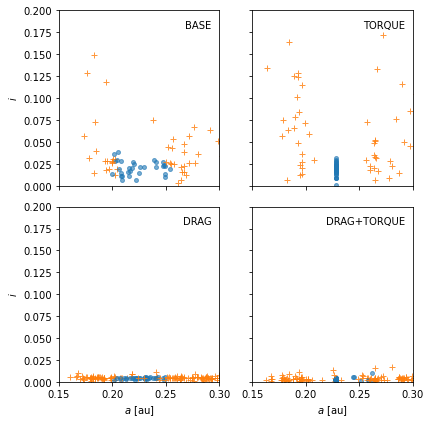

In [8]:
import matplotlib.pyplot as plt

def sim_group(row):
    g = 0
    if row["C_d"] == 0.44:
        g += 2
    if row["migration_torque"]:
        g += 1
    return g

def standard_label(axs, **kwargs):
    axs[0][0].annotate("BASE", **kwargs)
    axs[0][1].annotate("TORQUE", **kwargs)
    axs[1][0].annotate("DRAG", **kwargs)
    axs[1][1].annotate("DRAG+TORQUE", **kwargs)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
axs_r = np.ravel(axs)

for _i, row in sims_ext_df.iterrows():
    g = sim_group(row)
    ax = axs_r[g]

    final =  load_sim_from_cache(row["run"], 2000000)
    m = np.array([p.m for p in final.particles[1:]])
    M_TOT = np.sum(m)
    ipri = np.argmax(m)

    for i, p in enumerate(final.particles[1:]):
        if i == ipri:
            ax.plot(p.a, p.inc, marker="o", c="tab:blue", alpha=0.6, ms=4)
        else:
            ax.plot(p.a, p.inc, marker="+", c="tab:orange", alpha=0.8)

for ax in axs_r:
    ax.set_xlim(0.15, 0.30)
    ax.set_ylim(0, 0.2)

axs[0][0].set_ylabel(r"$i$")
axs[1][0].set_ylabel(r"$i$")

axs[1][0].set_xlabel(r"$a$ [au]")
axs[1][1].set_xlabel(r"$a$ [au]")

standard_label(axs, xy=(0.95, 0.90), xycoords='axes fraction', horizontalalignment="right")

fig.tight_layout()
plt.show()

In [7]:
sa1 = rebound.SimulationArchive("data/rebound_archive_15161.bin")
sa2 = rebound.SimulationArchive("data/IOPFPlanets20220810/iopf_sim_DRAG_0.0_NPA_a_0.22_0.24_e_0.02_i_0.01_15161/rebound_archive_15161.bin")

ts = [0, 30, 300, 3000, 30000, 300000, 2000000]

plt.rc("axes", prop_cycle=cycler(color=["cassum:blue"]))

fig, axs = plt.subplots(3, 7, figsize=(16, 8), sharex=True, sharey="row")
for i, t in enumerate(ts):
    if t > sa1.tmax:
        sim = sa2.getSimulation(t)
    else:
        sim = sa1.getSimulation(t)

    a, m, e, inc, z = np.array([(p.a, (p.m*7e7)**(4./3), p.e, p.inc, p.z) for p in sim.particles[1:]]).T

    axs[0][i].scatter(a, e, m)
    axs[0][i].set_title(fr"t = {t} years")
    axs[1][i].scatter(a, inc * 180 / np.pi, m)
    axs[2][i].scatter(a, z, m)
    axs[2][i].set_xlabel("$a$ [au]")

axs[0][0].set_xlim(0.20, 0.28)
axs[0][0].set_xticks([0.22, 0.24, 0.26])
axs[0][0].set_ylim(0, 0.15)
axs[0][0].set_ylabel("$e$")

axs[1][0].set_ylim(0, 5)
axs[1][0].set_ylabel("$i$ [deg]")

axs[2][0].set_ylim(-0.005 * 2.3, 0.005 * 2.3)
axs[2][0].set_ylabel("$z$ [au]")

for ax in np.ravel(axs):
    ax.set_facecolor("none")

for ax in np.ravel(axs[:, 1:]):
    ax.tick_params(axis='y', which='both', length=0)

for ax in np.ravel(axs[:-1, :]):
    ax.tick_params(axis='x', which='both', length=0)


plt.tight_layout()

# plt.savefig("images/evolve.png", dpi=200)


ValueError: 'cassum:blue' does not look like a color arg

/home/alchzh/cassum-2022-project-21/workspace/src/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Text(0.5, 0, '$t_{\\mathrm{norm}} [yr]$')

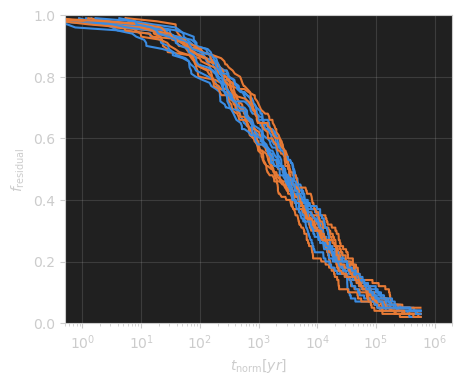

In [16]:
fig, axs = plt.subplots(1, 1, squeeze=False, figsize=(5, 4))

base_wide = base[base["a_in"] < 0.221]

for i, row in base.iterrows():
    p = str(row["path"] / row["rebound_archive"])
    hfp = p.replace("20220810", "20220823HF")

    sa1 = rebound.SimulationArchive(hfp)
    sa2 = rebound.SimulationArchive(p)

    Ts = []
    Ns = []

    for _im in range(1, len(sa1)):
        sim = sa1[_im]
        Ts.append(sim.t)
        Ns.append(sim.N-1)

    _im = sa2._getSnapshotIndex(sa1.tmax)[0]+1
    for _i in range(_im+1, len(sa2)):
        sim = sa2[_i]
        Ts.append(sim.t)
        Ns.append(sim.N-1)

    ax = axs[0, 0]
    ax.plot(np.array(Ts)/(2.3**(3./2)), np.array(Ns)/100)

ax = axs[0, 0]
ax.grid(alpha=0.2)
ax.set_ylim(0, 1.0)
ax.set_xlim(0.5, 2000000)
ax.set_xscale("log")

ax.set_ylabel(r"$f_{\mathrm{residual}}$")
ax.set_xlabel(r"$t_{\mathrm{norm}} [yr]$")

# plt.savefig("images/residual.png", dpi=200)

In [15]:
base["a_in"]

1     0.222
5     0.222
9     0.222
13    0.222
17    0.222
21    0.222
25    0.222
29    0.222
33    0.222
37    0.222
41    0.222
45    0.222
49    0.222
53    0.222
57    0.222
61    0.222
Name: a_in, dtype: float64

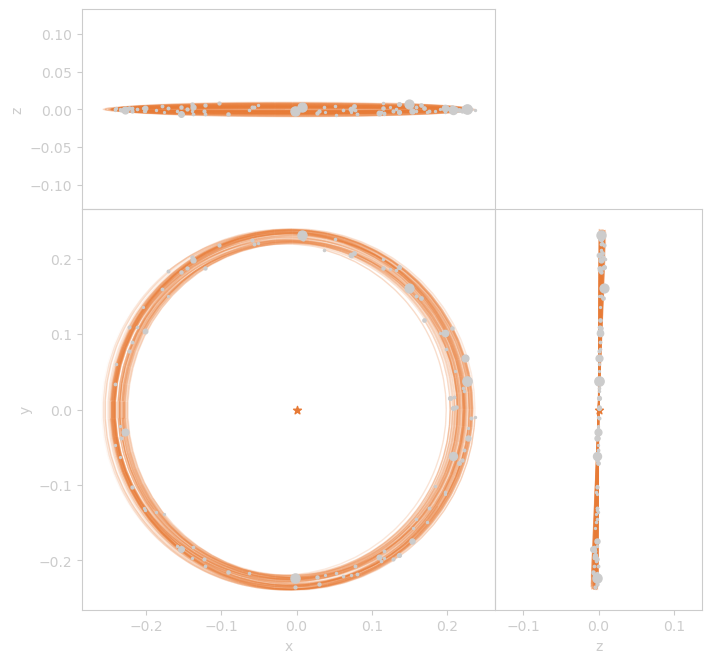

In [50]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.rcsetup import cycler

matplotlib.colors.cnames['cassum:orange'] = "#e77a35"
matplotlib.colors.cnames['cassum:blue'] = "#3b8ce2"

# -*- coding: utf-8 -*-
import math
from rebound.particle import Particle
from itertools import cycle

def OrbitPlot(sim, figsize=None, fancy=False, slices=0, xlim=None, ylim=None, unitlabel=None, color=False, periastron=False, orbit_type="trail", lw=1., plotparticles=None, primary=None, Narc=128):
    """
    Convenience function for plotting instantaneous orbits.

    Parameters
    ----------
    sim             : Simulation
    figsize         : tuple of float, optional
        Tuple defining the figure size (default: (5,5))
    fancy           : bool (default: False)
        Changes various settings to create a fancy looking plot
    slices          : float, optional
        Default is 0, showing the orbits in the xy plane only. Set to a value between 0 and 1 to create three plots, showing the orbits from different directions. The value corresponds to the size of the additional plots relative to the main plot.
    xlim            : tuple of float, optional           
        Limits for x axes (default: None = automatically determined)
    ylim            : tuple of float, optional           
        Limits for y axes (default: None = automatically determined)
    unitlabel       : str, optional          
        String describing the units, shown on axis labels (default: None)
    color           : bool, str or list, optional            
        By default plots are black and white. If set to True, plots use a color cycle. If a string or list of strings, e.g. ['red', 'cyan'], will cycle between passed colors.
    periastron  : bool, optional            
        Draw a marker at periastron (default: False)
    orbit_type       : str, optional
        This argument determines the type of orbit show. By default, it shows the orbit as a trailing and fading line ("trail"). Other object are: "solid", None.
    lw              : float, optional           
        Linewidth used in plots (default: 1.)
    plotparticles   : list, optional
        List of particles to plot. Can be a list of any valid keys for accessing sim.particles, i.e., integer indices or hashes (default: plot all particles)
    primary         : rebound.Particle, optional
        Primary to use for the osculating orbit (default: Jacobi center of mass)
    Narc            : int, optional
        Number of points used in an orbit. Increase this number for highly eccentric orbits. (default: 128)

    Returns
    -------
    fig, ax_main, (ax_top, ax_right)
        The function return the matplotlib figure as well as the axes (three axes if slices>0.)

    Examples
    --------
    The following example illustrates a typical use case.

    >>> sim = rebound.Simulation()
    >>> sim.add(m=1)
    >>> sim.add(a=1)
    >>> fig, ax_main = rebound.OrbitPlot(sim)
    >>> fig.savefig("image.png") # save figure to file
    >>> fig.show() # show figure on screen

    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib import gridspec
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        import numpy as np
    except:
        raise ImportError("Error importing matplotlib and/or numpy. Plotting functions not available. If running from within a jupyter notebook, try calling '%matplotlib inline' beforehand.")
    if not plotparticles:
        plotparticles = []
    if unitlabel is not None:
        unitlabel = " " + unitlabel
    else:
        unitlabel = ""
    if figsize is None:
        if slices>0.:
            figsize = (8,8)
        else:
            figsize = (5,5)
    
    fig = plt.figure(figsize=figsize)
    ax_main = plt.subplot(111,aspect="equal")
    ax_main.set_xlabel("x"+unitlabel)
    ax_main.set_ylabel("y"+unitlabel)

    if slices>0.:
        divider = make_axes_locatable(ax_main)
        divider.set_aspect(True)
        ax_top   = divider.append_axes("top",  size="%.2f%%"%(100.*slices), sharex=ax_main, pad=0)
        ax_top.set_aspect('equal', adjustable='datalim')
        ax_right = divider.append_axes("right", size="%.2f%%"%(100.*slices), sharey=ax_main, pad=0)
        ax_right.set_aspect('equal', adjustable='datalim')
      
        plt.setp(ax_top.get_xticklabels(), visible=False)
        plt.setp(ax_top.get_xticklines(), visible=False)
        ax_top.set_ylabel("z"+unitlabel)
        
        plt.setp(ax_right.get_yticklabels(), visible=False)
        plt.setp(ax_right.get_yticklines(), visible=False)
        ax_right.set_xlabel("z"+unitlabel)

    OrbitPlotOneSlice(sim, ax_main, Narc=Narc, color=color, periastron=periastron, orbit_type=orbit_type, lw=lw, axes="xy",fancy=fancy, plotparticles=plotparticles, primary=primary, xlim=xlim, ylim=ylim)

    if slices>0.:
        OrbitPlotOneSlice(sim, ax_right, Narc=Narc, color=color, periastron=periastron, orbit_type=orbit_type, lw=lw,fancy=fancy, axes="zy", plotparticles=plotparticles, primary=primary)
        OrbitPlotOneSlice(sim, ax_top, Narc=Narc, color=color, periastron=periastron, orbit_type=orbit_type, lw=lw,fancy=fancy, axes="xz", plotparticles=plotparticles, primary=primary)

    if fancy:
        ax_main.apply_aspect()
        if slices>0.:
            ax_top.apply_aspect()
            ax_right.apply_aspect()
        ax_main.autoscale(False)
        if slices>0.:
            ax_top.autoscale(False)
            ax_right.autoscale(False)
        OrbitPlotAddFancyStars(ax_main,lw)
        if slices>0.:
            OrbitPlotAddFancyStars(ax_top,lw,slices)
            OrbitPlotAddFancyStars(ax_right,lw,slices)
    if slices>0.:
        return fig, ax_main, ax_top, ax_right
    else:
        return fig, ax_main

def get_color(color):
    """
    Takes a string for a color name defined in matplotlib and returns of a 3-tuple of RGB values.
    Will simply return passed value if it's a tuple of length three.

    Parameters
    ----------
    color   : str
        Name of matplotlib color to calculate RGB values for.
    """

    if isinstance(color, tuple) and len(color) == 3: # already a tuple of RGB values
        return color

    try:
        import matplotlib.colors as mplcolors
    except:
        raise ImportError("Error importing matplotlib. If running from within a jupyter notebook, try calling '%matplotlib inline' beforehand.")
   
    try:
        hexcolor = mplcolors.cnames[color]
    except KeyError:
        raise AttributeError("Color not recognized in matplotlib.")

    hexcolor = hexcolor.lstrip('#')
    lv = len(hexcolor)
    return tuple(int(hexcolor[i:i + lv // 3], 16)/255. for i in range(0, lv, lv // 3)) # tuple of rgb values

def fading_line(x, y, color='black', alpha=1, fading=True, fancy=False, **kwargs):
    """
    Returns a matplotlib LineCollection connecting the points in the x and y lists.
    Can pass any kwargs you can pass to LineCollection, like linewidgth.

    Parameters
    ----------
    x       : list or array of floats for the positions on the (plot's) x axis.
    y       : list or array of floats for the positions on the (plot's) y axis.
    color   : Color for the line. 3-tuple of RGB values, hex, or string. Default: 'black'.
    alpha   : float, alpha value of the line. Default 1.
    fading  : bool, determines if the line is fading along the orbit.
    fancy   : bool, same as fancy argument in OrbitPlot()
    """
    try:
        from matplotlib.collections import LineCollection
        import numpy as np
    except:
        raise ImportError("Error importing matplotlib and/or numpy. Plotting functions not available. If running from within a jupyter notebook, try calling '%matplotlib inline' beforehand.")


    if "lw" not in kwargs:
        kwargs["lw"] = 1
    lw = kwargs["lw"]

    if fancy:
        kwargs["lw"] = 1*lw
        fl1 = fading_line(x, y, color=color, alpha=alpha, fading=fading, fancy=False, **kwargs)
        kwargs["lw"] = 2*lw
        alpha *= 0.5
        fl2 = fading_line(x, y, color=color, alpha=alpha, fading=fading, fancy=False, **kwargs)
        kwargs["lw"] = 6*lw
        alpha *= 0.5
        fl3 = fading_line(x, y, color=color, alpha=alpha, fading=fading, fancy=False, **kwargs)
        return [fl3,fl2,fl1]
    
    Npts = len(x)
    if len(y) != Npts:
        raise AttributeError("x and y must have same dimension.")
    
    color = get_color(color)
    colors = np.zeros((Npts,4))
    colors[:,0:3] = color
    if fading:
        colors[:,3] = alpha*np.linspace(0,1,Npts)
    else:
        colors[:,3] = alpha
   
    segments = np.zeros((Npts-1,2,2))
    segments[:,0,0] = x[:-1]
    segments[:,0,1] = y[:-1]
    segments[:,1,0] = x[1:]
    segments[:,1,1] = y[1:]

    lc = LineCollection(segments, color=colors, **kwargs)
    return lc

def OrbitPlotOneSlice(sim, ax, Narc=128, color=False, periastron=False, orbit_type="trial", lw=1., axes="xy", plotparticles=None, primary=None, fancy=False, xlim=None, ylim=None):
    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection
    import numpy as np
    import random

    if not plotparticles:
        plotparticles = []
    #ax.set_aspect("equal")
    p_orb_pairs = []
    if not plotparticles:
        plotparticles = range(1, sim.N_real)
    for i in plotparticles:
        p = sim.particles[i]
        p_orb_pairs.append((p, p.calculate_orbit(primary=primary)))


    if color:
        if color == True:
            colors = [(1.,0.,0.),(0.,0.75,0.75),(0.75,0.,0.75),(0.75, 0.75, 0,),(0., 0., 0.),(0., 0., 1.),(0., 0.5, 0.)]
        if isinstance(color, str):
            colors = [get_color(color)]
        if isinstance(color, list):
            colors = []
            for c in color:
                colors.append(get_color(c))
    else:
        if fancy:
            colors = [(181./206.,66./206.,191./206.)]
        else:
            colors = ["black"]
    coloriterator = cycle(colors)

    coords = {'x':0, 'y':1, 'z':2}
    axis0 = coords[axes[0]]
    axis1 = coords[axes[1]]
   
    prim = sim.particles[0] if primary is None else primary 
    if fancy:
        sun = (256./256.,256./256.,190./256.)
        opa = 0.035
        size = 6000.
        for i in range(100):
            ax.scatter(getattr(prim,axes[0]),getattr(prim,axes[1]), alpha=opa, s=size*lw, facecolor=sun, edgecolor=None, zorder=3)
            size *= 0.95
        ax.scatter(getattr(prim,axes[0]),getattr(prim,axes[1]), s=size*lw, facecolor=sun, edgecolor=None, zorder=3)
    else:
        ax.scatter(getattr(prim,axes[0]),getattr(prim,axes[1]), marker="*", s=35*lw, facecolor="cassum:orange", edgecolor=None, zorder=3)
    
    proj = {}
    
    xmin = []
    xmax = []
    ymin = []
    ymax = []

    max_mass = max(p.m for p, _ in p_orb_pairs)

    for p, o in p_orb_pairs:
        prim = p.jacobi_com if primary is None else primary 
        for _p in [p,prim]:
            xmax.append(_p.xyz[axis0])
            xmin.append(_p.xyz[axis0])
            ymax.append(_p.xyz[axis1])
            ymin.append(_p.xyz[axis1])

        colori = next(coloriterator)

        if fancy:
            ax.scatter(getattr(p,axes[0]), getattr(p,axes[1]), s=45*lw*p.m/max_mass, facecolor=colori, edgecolor=None, zorder=3)
        else:
            ax.scatter(getattr(p,axes[0]), getattr(p,axes[1]), s=45*lw*p.m/max_mass, facecolor="#ccc", edgecolor=None, zorder=3)
       
        if orbit_type is not None:
            pts = np.array(p.sample_orbit(Npts=Narc+1, primary=prim))
            proj['x'],proj['y'],proj['z'] = [pts[:,i] for i in range(3)]

            # Estimate limits
            if o.a < 0.: # hyperbolic
                xmax.append(p.xyz[axis0])
                xmin.append(p.xyz[axis0])
                ymax.append(p.xyz[axis1])
                ymin.append(p.xyz[axis1])
            else: # circular
                xmax.append(max(proj[axes[0]]))
                xmin.append(min(proj[axes[0]]))
                ymax.append(max(proj[axes[1]]))
                ymin.append(min(proj[axes[1]]))
            
            if orbit_type=="trail":
                fading = True
            elif orbit_type=="solid":
                fading = False
            else:
                raise ValueError("Unknown orbit_type.")
            lc = fading_line(proj[axes[0]], proj[axes[1]], color=colori, lw=lw, fancy=fancy, fading=fading, alpha=0.30)
            if type(lc) is list:
                for l in lc:
                    ax.add_collection(l)
            else:
                ax.add_collection(lc)

        if periastron:
            newp = Particle(a=o.a, f=0., inc=o.inc, omega=o.omega, Omega=o.Omega, e=o.e, m=p.m, primary=prim, simulation=sim)
            ax.plot([getattr(prim,axes[0]), getattr(newp,axes[0])], [getattr(prim,axes[1]), getattr(newp,axes[1])], linestyle="dotted", c=colori, zorder=1, lw=lw)
            ax.scatter([getattr(newp,axes[0])],[getattr(newp,axes[1])], marker="o", s=5.*lw, facecolor="none", edgecolor=colori, zorder=1)

    if xmax:
        xmax = max(xmax)
        xmin = min(xmin)
        width = xmax-xmin
        ymax = max(ymax)
        ymin = min(ymin)
        height = ymax-ymin
    
        # prevent overly elongated plots
        ymin -= width/10.
        ymax += width/10.
        
        xmin -= height/10.
        xmax += height/10.

    if xlim is not None:
        ax.set_xlim(xlim)
    elif xmax:
        ax.set_xlim([xmin-0.05*width,xmax+0.05*width])
    if ylim is not None:
        ax.set_ylim(ylim)
    elif xmax:
        ax.set_ylim([ymin-0.05*height,ymax+0.05*height])



def OrbitPlotAddFancyStars(ax,lw,slices=1.):
    import numpy as np
    # safe the current random seed to restore later
    os = np.random.get_state()
    # always produce the same stars
    np.random.seed(1) 

    ax.set_facecolor((0.,0.,0.))
    for pos in ['top', 'bottom', 'right', 'left']:
        ax.spines[pos].set_edgecolor((0.3,0.3,0.3))
    
    starcolor = (1.,1.,1.)
    starsurfacedensity = 0.8

    area = np.sqrt(np.sum(np.square(ax.transAxes.transform([1.,1.]) - ax.transAxes.transform([0.,0.]))))*slices
    nstars = int(starsurfacedensity*area)

    #small stars
    xy = np.random.uniform(size=(nstars,2))
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.05, s=8*lw, facecolor=starcolor, edgecolor=None, zorder=3)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.1, s=4*lw, facecolor=starcolor, edgecolor=None, zorder=3)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.2, s=0.5*lw, facecolor=starcolor, edgecolor=None, zorder=3)
    
    #large stars
    xy = np.random.uniform(size=(nstars//4,2))
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.1, s=15*lw, facecolor=starcolor, edgecolor=None, zorder=3)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.1, s=5*lw, facecolor=starcolor, edgecolor=None, zorder=3)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.5, s=2*lw, facecolor=starcolor, edgecolor=None, zorder=3)

    np.random.set_state(os)


plt.rcdefaults()

fg = "#ccc"

plt.rc("axes",
    prop_cycle=cycler(color=["cassum:orange", "cassum:blue"]),
    facecolor="none",
    labelcolor=fg,
    edgecolor=fg
)
plt.rc("figure", facecolor="none")


plt.rc("xtick", color=fg, labelcolor=fg)
plt.rc("ytick", color=fg, labelcolor=fg)
# plt.rc("axes.spines", top=False, right=False)

OrbitPlot(sa1.getSimulation(0), slices=0.5, color=["cassum:orange"])
plt.savefig("images/orbit_init.png", dpi=200)